<h1>Quantum inspired solution of burger's equation</h1>
Using quimb and quantum tensor networks

In [1]:
#Uncomment to install quimb
#!pip install quimb

### Outline:
<ol>
<li>Introduction</li>
<li>Required imports</li>
<li>Running the full solution</li>
<li>Running the full solution with penalty term</li>
<li>Comparison with the analytical solution</li>
<li>References</li>
<li>Versions</li>
</ol>

### Introduction:
Quimb is an easy but fast python library for 'quantum information many-body' calculations, focusing primarily on tensor networks. In this notebook we will use quimb to build the quantum-inspired solution from the QTN paper "Quantum-inspired framework for computational fluid dynamics".

As the paper solves the 2D navier-stokes equation, we will start first by explaining the terms and structure of the navier-stokes then explaining how it differs from the 1D burger's equation required to be solved by the guidelines of the project "Quantum algorithm as a PDE solver for computational fluid dynamics".

1) Navier-Stokes equation:
\begin{align}
\frac{\partial u}{\partial t} + {(u \cdot \nabla)}u &= -\frac{1}{\rho} \nabla p + \nu \nabla^2 u \tag{1a} \\
\nabla \cdot u &= 0 \tag{1b}
\end{align}

2) Burger's equation:
\begin{equation}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2} \tag{2}
\end{equation}


Starting with the navier stokes, these 2 equations (1a)
and (1b) follow respectively from momentum and mass
conservations.
<ul>
<li>$u$: velocity vector</li>
<li>$\rho$: density</li>
<li>$\nabla$: laplacian</li>
<li>$p$: pressure</li>
<li>$\nu$: viscosity</li>
</ul>

The Navier-Stokes equations are a set of partial differential equations that describe the motion of viscous fluid substances. They are notoriously difficult to solve due to their nonlinearity and the complex interactions they describe.


Burgers' equation is a simplified model that shares some key characteristics with the Navier-Stokes equations. However, it eliminates several crucial concepts present in the full Navier-Stokes equations, making it much simpler to analyze and sometimes even solve analytically.



Burgers' equation retains the fundamental competition between **non-linear advection (convection)**, which can lead to shock formation, and **linear diffusion (viscosity)**, which tends to smooth out these sharp gradients. This makes it an excellent "toy model" for understanding phenomena like shock waves and the general behavior of non-linear PDEs, but it sacrifices the full complexity of real-world fluid dynamics by eliminating pressure, reducing dimensionality, and simplifying viscous effects.

### Required imports:

In [2]:
import numpy as np
import time
import quimb.tensor as qtn
import matplotlib.pyplot as plt
from scipy.sparse import diags # For efficient creation of sparse matrices
from collections import Counter

### Building block functions of the solution:

In [3]:
def riemann_step(N):
    """
    Create a Riemann step function of length N as a NumPy float array.

    Parameters:
    - N (int): even number representing the total number of grid points.

    Returns:
    - (ndarray): An array representing the Riemann step of half 1's then half 0's.
    """
    half = N // 2
    return np.concatenate([
        np.ones(half, dtype=np.float64),
        np.zeros(N - half, dtype=np.float64)
    ])

The burgers equation contains two terms, one called convection and the other called diffusion term. These two terms are the ones having derivative with respect to x. By other words, they are the spatial (space) and not temporal (time) derivatives.

<ul>
<li>Convection term: $u \frac{\partial u}{\partial x}$ , this term moves the plot to the right when velocity u is positive.</li>
<li>Diffusion term: $\nu \frac{\partial^2 u}{\partial x^2}$ , this term is responisble for the smooth shape of the plot.</li>
</ul>

As can be seen, the convection term is nonlinear since $u$ is multiplied by the derivative of $u$. In fact, the vector $u$ is transformed from the dense vector got from the riemann_step function into an MPS (matrix product state) using Quimb.

If we apply $\frac{\partial }{\partial x}$ on $u$ we get another MPS, and since multiplied by $u$ we get an MPS multiplied by an MPS. But Quimb does not have the function to multiply two MPS so we build our own called "mps_elementwise_multiply" in the following cell.

In [4]:
def mps_elementwise_multiply(mps1, mps2):
    """
    Elementwise (Hadamard) product of two MPS.
    Assumes both have same number of sites.

    Parameters:
    - mps1 (MPS): first matrix product state.
    - mps2 (MPS): second matrix product state.
    """

    # Count all index occurrences to find unique (physical) ones
    all_inds1 = [ind for tensor in mps1 for ind in tensor.inds]
    ind_counts1 = Counter(all_inds1)

    all_inds2 = [ind for tensor in mps2 for ind in tensor.inds]
    ind_counts2 = Counter(all_inds2)

    result_tensors = []
    C = mps1.copy()

    for i in range(8):
        A = mps1[i]
        B = mps2[i]

        # Physical index = appears only once in the network
        phys_ind_A = next(ind for ind in A.inds if ind_counts1[ind] == 1)
        phys_ind_B = next(ind for ind in B.inds if ind_counts2[ind] == 1)

        # Reindex B's physical index to match A's
        B = B.reindex({phys_ind_B: phys_ind_A})

        # Rename bond indices of B to avoid collisions with A
        B = B.reindex({ind: f"{ind}_b" for ind in B.inds if ind != phys_ind_A})

        # Multiply tensors (elementwise on physical index)
        result = A * B

        C[i] = result

    return C

\begin{equation}
\mathbf{C}
\;=\;
\frac{1}{2\,\Delta x}
\begin{pmatrix}
0      & 1      & 0      & \cdots & 0      \\
-1     & 0      & 1      & \ddots & \vdots \\
0      & \ddots & \ddots & \ddots & 0      \\
\vdots & \ddots & -1     & 0      & 1      \\
0      & \cdots & 0      & -1     & 0
\end{pmatrix},
\quad
\mathbf{D}
\;=\;
\frac{1}{\Delta x^2}
\begin{pmatrix}
-2     & 1      & 0      & \cdots & 0      \\
1      & -2     & 1      & \ddots & \vdots \\
0      & \ddots & \ddots & \ddots & 0      \\
\vdots & \ddots & 1      & -2     & 1      \\
0      & \cdots & 0      & 1      & -2
\end{pmatrix}
\end{equation}

The following function "create_dirichlet_fd_matrix", creates these two operators and enforces dirichlet boundaries. 1 at the left and 0 at the right, but we will see later that this enforcement of dirichlet boundaries is not enough and other approaches need to be added.

In [5]:
def create_dirichlet_fd_matrix(N, dx, order, left_bc=1.0, right_bc=0.0):
    """
    Create a dense finite difference matrix with Dirichlet boundary conditions applied
    directly to the matrix so that it sets u[0] = left_bc and u[-1] = right_bc.

    Parameters:
    - N (int): number of grid points
    - dx (float): grid spacing
    - order (int): 1 for first derivative, 2 for second derivative
    - left_bc (float): Dirichlet boundary value at the left end
    - right_bc (float): Dirichlet boundary value at the right end

    Returns:
    - mat (ndarray): NxN matrix that enforces Dirichlet BCs
    """
    if order == 1:
        # Central difference for interior points
        offsets = [-1, 1]
        data = [-np.ones(N) / (2 * dx), np.ones(N) / (2 * dx)]
        mat = diags(data, offsets, shape=(N, N), format='csc').toarray()

        # Enforce Dirichlet BCs at boundaries
        mat[0, :] = 0.0
        mat[0, 0] = left_bc

        mat[-1, :] = 0.0
        mat[-1, -1] = right_bc

    elif order == 2:
        # Central difference for second derivative
        offsets = [-1, 0, 1]
        data = [np.ones(N) / dx**2,
                -2.0 * np.ones(N) / dx**2,
                np.ones(N) / dx**2]
        mat = diags(data, offsets, shape=(N, N), format='csc').toarray()

        # Enforce Dirichlet BCs at boundaries
        mat[0, :] = 0.0
        mat[0, 0] = left_bc

        mat[-1, :] = 0.0
        mat[-1, -1] = right_bc

    else:
        raise ValueError("Order must be 1 or 2 for finite difference.")

    return mat

The next cell applies the penalty term method which will be explained later.

In [6]:
def boundary_target_penalty_mpo(N, dims=2, target_value=1.01, penalty_strength=0.85e-2, target_idx=0):
    """
    Construct a diagonal MPO that penalizes deviation from a target value
    at a specific boundary index.

    Parameters:
    - N (int): total grid points
    - dims (int): physical dimension at each site
    - target_value (float): desired value at boundary
    - penalty_strength (float): strength of penalty
    - target_idx (int): index of grid point to enforce

    Returns:
    - MPO: MatrixProductOperator that applies the soft penalty
    - target_mps: MPS encoding the target profile (mostly zeros, with value at target_idx)
    """
    # Penalty operator: zero everywhere except target_idx
    penalty_diag = np.zeros(N)
    penalty_diag[target_idx] = penalty_strength
    penalty_matrix = np.diag(penalty_diag)
    penalty_mpo = qtn.tensor_1d.MatrixProductOperator.from_dense(penalty_matrix, dims=dims)

    # Target profile vector: zero everywhere except target_idx = target_value
    target_profile = np.zeros(N)
    target_profile[target_idx] = target_value
    target_mps = qtn.tensor_1d.MatrixProductState.from_dense(target_profile, dims=2)

    return penalty_mpo, target_mps

### Running the full solution:

| **Algorithm Step**            | **Navier–Stokes (2D/3D)**                                                                 | **1D Burgers’ Equation**                                                   |
|-------------------------------|-------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------|
| Field encoding                | Velocity $\mathbf{v}(x,y,(z))$ and pressure $p(x,y,(z))$ encoded as MPSs                   | Scalar velocity $u(x)$ encoded as a single‐chain MPS                        |
| Domain discretization         | Bit‐string length $N = N_x + N_y\,(+N_z)$ for a 2D/3D mesh                                 | Bit‐string length $N$ for a 1D mesh                                         |
| Mask application              | Apply approximate MPS masks to enforce no‐slip inside objects                              | Simple boundary mask enforced by dirichlet boundary (velocity 0 at the right)                             |
| Divergence‐free projection    | Chorin’s projection: | Not needed by burger's equation                                |
| Differential operators as MPOs| Finite‐difference Laplacian & gradient stencils with inlet–outlet BCs                       | Finite‐difference $\partial_x$ & $\partial_{xx}$ stencils with Dirichlet BCs |
| Time integration              | Explicit Euler (or RK/Crank–Nicolson) + split‐step projection                              | Explicit Euler (or RK)|
| Bond‐dimension control        | After each MPS operation, truncate singular values $<\varepsilon$   | Same SVD‐based truncation strategy                                           |
| MPS solution oracle           | Coarse‐graining or pixel sampling| plotting of dense vector after uncompression from MPS                                             |


The above table shows some differences in the steps done in the paper on navier stokes and by us done on 1D burger's equation. As the burger's equation is simpler, some steps are not needed like chorin's projection. Also, in the end they plot the velocity without transforming into dense using pixel sampling but we transform into dense then we plot. But it is worth mentioning that both solutions for navier-stokes and our solution perform the operations on the compressed MPS which leads to exponentially fewer resources. We just only transform to dense after all steps are finished, just for plotting.

In [7]:
# --- Parameters for the Simulation ---
N_sites = 8  # Number of sites (bits) in the MPS, so 2^N_sites grid points
N_grid_points = 2**N_sites # Total number of grid points
L_domain = 1  # Spatial domain length [0, 1]
dx = L_domain / (N_grid_points - 1)  # Grid spacing (assuming endpoint=True)
nu = 0.001  # Kinematic viscosity (diffusion coefficient)
dt = 0.001  # Time step size
T_end = 5  # Total simulation time
max_bond = 30  # Maximum bond dimension allowed for MPS truncation

In [8]:
# --- Spatial Grid ---
# Create a 1D spatial grid with 2^N_sites points
x = np.linspace(0, L_domain, N_grid_points, endpoint=True)

# --- Initial Condition ---
u0_dense = riemann_step(N_grid_points)

# --- Convert Initial Condition to Matrix Product State (MPS) ---
# qtn.MPS.from_dense attempts to compress a dense vector into an MPS.
# The 'dims=2' means each site in the MPS corresponds to a binary index (a bit).
# 'bond_dim' is the initial maximum bond dimension for this compression.

u_mps = qtn.MPS_rand_state(L=20, bond_dim=max_bond)
u_mps = qtn.tensor_1d.MatrixProductState.from_dense(u0_dense, dims=2)
u_mps.compress(max_bond=max_bond)
print(f"Initial MPS bond dimensions (max): {u_mps.max_bond()}")

Initial MPS bond dimensions (max): 1


The convection and diffusion operators built as matrices need to be applied on an MPS, Happily, one of the powers of Quimb is that it has prebuilt functions to transform such matrices into operators specifically, MPO's (matrix product operators) and also has built in functions to apply MPO's on an MPS.

In [9]:
# --- Construct Matrix Product Operators (MPOs) for Burger's Equation Terms ---
D1_dense_matrix = create_dirichlet_fd_matrix(N_grid_points, dx, order=1)
D2_dense_matrix = create_dirichlet_fd_matrix(N_grid_points, dx, order=2)

# Convert matrices to MPOs
# The 'dims=2' specifies that each site in the MPO corresponds to a binary physical dimension.
MPO_dx = qtn.tensor_1d.MatrixProductOperator.from_dense(D1_dense_matrix, dims=2)
MPO_d2x = qtn.tensor_1d.MatrixProductOperator.from_dense(D2_dense_matrix, dims=2)

print(f"MPO for d/dx bond dimensions (max): {MPO_dx.max_bond()}")
print(f"MPO for d^2/dx^2 bond dimensions (max): {MPO_d2x.max_bond()}")

MPO for d/dx bond dimensions (max): 5
MPO for d^2/dx^2 bond dimensions (max): 5


After applying the MPO's on the MPS $u$ we now use euler's method to calculate $u$(t+dt) from $u$(t). The following cell prepares some code like num_steps and list to store the history, before performing the for loop. In this loop the following steps are repeated:

<ol>
<li>The diffusion term is calculated by applying the diffusion MPO on the MPS $u$.</li>
<li>The convection term is calculated by applying the convection MPO on the MPS $u$ and then multiplying bu the MPS $u$.</li>
<li>After each multiplication or operation of an MPO, the compress function is used for truncation since after each operation the bond dimension increases. This decreases the increased bond dimension after each step.</li>
</ol>

In [10]:
# --- Time Evolution Loop (Explicit Euler Method) ---
# The Burger's equation can be written as: ∂u/∂t = -u * (∂u/∂x) + ν * (∂^2u/∂x^2)
# Using Explicit Euler: u(t+dt) = u(t) + dt * ( -u * (∂u/∂x) + ν * (∂^2u/∂x^2) )
current_u_mps = u_mps.copy() # Start with the initial condition

current_u_mps /= current_u_mps.norm()
# Lists to store results for plotting
u_history = [current_u_mps.to_dense()] # Store initial state
times = [0.0]

In [11]:
num_steps = int(T_end / dt)
print(f"\nStarting simulation for {num_steps} steps (total time = {T_end})...")

for step in range(num_steps):
    # 1. Calculate the Viscous Term: ν * (∂^2u/∂x^2)
    # Apply the second derivative MPO to the current MPS.
    viscous_term_mps = MPO_d2x.apply(current_u_mps, compress=True)
    # Scale by the viscosity coefficient (nu).
    viscous_term_mps = viscous_term_mps * nu
    # Compress/truncate the MPS to control bond dimension growth after scaling.
    viscous_term_mps.compress(max_bond=max_bond)

    # 2. Calculate the Non-Linear Term: -u * (∂u/∂x)
    # First, calculate ∂u/∂dx by applying the first derivative MPO.
    du_dx_mps = MPO_dx.apply(current_u_mps, compress=True)
    du_dx_mps.compress(max_bond=max_bond)

    # Now, perform the element-wise product u * (du/dx).
    # Performs an element-wise (Hadamard) product of two MPSs.
    # This operation can significantly increase the bond dimension, so immediate
    # compression is critical to maintain efficiency and prevent memory issues.
    nonlinear_term_mps = mps_elementwise_multiply(current_u_mps, du_dx_mps)
    nonlinear_term_mps.compress(max_bond=max_bond)

    # 3. Combine terms for the Right-Hand Side (RHS) of the equation:
    # RHS = - (u * du/dx) + (nu * d^2u/dx^2)
    # Perform MPS subtraction (which is handled as MPS addition with a negative scalar).
    rhs_mps = viscous_term_mps - nonlinear_term_mps
    rhs_mps.compress(max_bond=max_bond)

    # Scale the entire RHS by the time step (dt).
    rhs_mps = rhs_mps * dt
    rhs_mps.compress(max_bond=max_bond)

    # 4. Update u: u(t+dt) = u(t) + dt * RHS
    # Perform MPS addition to update the velocity field.
    current_u_mps = current_u_mps + rhs_mps
    # Final compression after the update to ensure bond dimension is controlled.
    current_u_mps.compress(max_bond=max_bond)

    # Print progress and current max bond dimension periodically
    if (step + 1) % (num_steps // 10) == 0 or step == num_steps - 1:
        print(f"  Step {step+1}/{num_steps}, Time: {(step + 1) * dt:.3f}, Max Bond Dim: {current_u_mps.max_bond()}")

    # Store data for plotting at certain intervals
    if (step + 1) % (num_steps // 5) == 0 or step == num_steps - 1:
        u_history.append(current_u_mps.to_dense())
        times.append((step + 1) * dt)

print("Simulation complete.")


Starting simulation for 5000 steps (total time = 5)...
  Step 500/5000, Time: 0.500, Max Bond Dim: 4
  Step 1000/5000, Time: 1.000, Max Bond Dim: 4
  Step 1500/5000, Time: 1.500, Max Bond Dim: 4
  Step 2000/5000, Time: 2.000, Max Bond Dim: 4
  Step 2500/5000, Time: 2.500, Max Bond Dim: 4
  Step 3000/5000, Time: 3.000, Max Bond Dim: 4
  Step 3500/5000, Time: 3.500, Max Bond Dim: 4
  Step 4000/5000, Time: 4.000, Max Bond Dim: 5
  Step 4500/5000, Time: 4.500, Max Bond Dim: 5
  Step 5000/5000, Time: 5.000, Max Bond Dim: 5
Simulation complete.


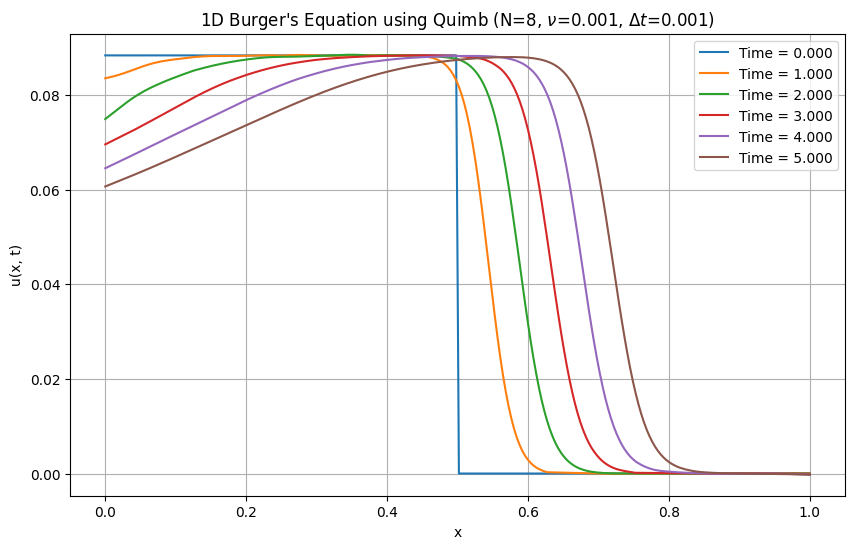

In [12]:
# --- Plotting Results ---
plt.figure(figsize=(10, 6))
for i, u_dense in enumerate(u_history):
    plt.plot(x, u_dense, label=f'Time = {times[i]:.3f}')

plt.title(f'1D Burger\'s Equation using Quimb (N={N_sites}, $\\nu$={nu}, $\\Delta t$={dt})')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.legend()
plt.grid(True)
plt.show()

### Running the full solution with penalty term:

Although the plots look nice but we have 1 problem, the dirichlet boundaries at the left are not enforced as this boundary value should be approximately 1. The reason for that is although dirichlet boundaries are enforced in the operator but the following line of code, current_u_mps = current_u_mps + rhs_mps, breaks this enforcement as it makes the boundary values change. To accomodate, we willalso use the penalty term method in addition to the enforcement in the operator.

One thing worth mentioning is that the operator keeps the left boundary value as it is but that line of code changes it.Also, most of the steps in the simulation stay the same with only few modifications.

In [13]:
# --- Parameters for the Simulation ---
N_sites = 8  # Number of sites (bits) in the MPS, so 2^N_sites grid points
N_grid_points = 2**N_sites # Total number of grid points
L_domain = 1  # Spatial domain length [0, 1]
dx = L_domain / (N_grid_points - 1)  # Grid spacing (assuming endpoint=True)
nu = 0.001  # Kinematic viscosity (diffusion coefficient)
dt = 0.001  # Time step size
T_end = 5  # Total simulation time
max_bond = 30  # Maximum bond dimension allowed for MPS truncation

In [14]:
# --- Spatial Grid ---
# Create a 1D spatial grid with 2^N_sites points
x = np.linspace(0, L_domain, N_grid_points, endpoint=True)

# --- Initial Condition ---
u0_dense = np.sin(x)
u0_dense = riemann_step(N_grid_points)

In [15]:
# --- Convert Initial Condition to Matrix Product State (MPS) ---
# qtn.MPS.from_dense attempts to compress a dense vector into an MPS.
# The 'dims=2' means each site in the MPS corresponds to a binary index (a bit).
# 'bond_dim' is the initial maximum bond dimension for this compression.

u_mps = qtn.MPS_rand_state(L=20, bond_dim=max_bond)
u_mps = qtn.tensor_1d.MatrixProductState.from_dense(u0_dense, dims=2)
u_mps.compress(max_bond=max_bond)
#u_mps = qtn.MPS.from_dense(u0_dense, dims=2, bond_dim=max_bond)
print(f"Initial MPS bond dimensions (max): {u_mps.max_bond()}")

Initial MPS bond dimensions (max): 1


In [16]:
# --- Construct Matrix Product Operators (MPOs) for Burger's Equation Terms ---

# Construct the dense matrices for the derivatives
D1_dense_matrix = create_dirichlet_fd_matrix(N_grid_points, dx, order=1)
D2_dense_matrix = create_dirichlet_fd_matrix(N_grid_points, dx, order=2)

# Convert dense matrices to MPOs
# The 'dims=2' specifies that each site in the MPO corresponds to a binary physical dimension.
MPO_dx = qtn.tensor_1d.MatrixProductOperator.from_dense(D1_dense_matrix, dims=2)
MPO_d2x = qtn.tensor_1d.MatrixProductOperator.from_dense(D2_dense_matrix, dims=2)

print(f"MPO for d/dx bond dimensions (max): {MPO_dx.max_bond()}")
print(f"MPO for d^2/dx^2 bond dimensions (max): {MPO_d2x.max_bond()}")

MPO for d/dx bond dimensions (max): 5
MPO for d^2/dx^2 bond dimensions (max): 5


In [17]:
# --- Time Evolution Loop (Explicit Euler Method) ---
# The Burger's equation can be written as: ∂u/∂t = -u * (∂u/∂x) + ν * (∂^2u/∂x^2)
# Using Explicit Euler: u(t+dt) = u(t) + dt * ( -u * (∂u/∂x) + ν * (∂^2u/∂x^2) )
current_u_mps = u_mps.copy() # Start with the initial condition

current_u_mps /= current_u_mps.norm()
# Lists to store results for plotting
u_history = [current_u_mps.to_dense()] # Store initial state
times = [0.0]

The main change happens in the following cell where the right hand side has the penalty term added to it.

rhs_mps = rhs_mps - penalty_term_mps

The penalty term comes from applying the penalty operator to an MPS. This shows the power of Quimb as being able to use operators and applying these operators to an MPS using buil-in functions in Quimb. We will add also timing in the following cell to check how much time is needed for the solution to run.

In [18]:
num_steps = int(T_end / dt)
print(f"\nStarting simulation for {num_steps} steps (total time = {T_end})...")

# Start timing before the simulation loop
start_time = time.time()

for step in range(num_steps):
    # 1. Calculate the Viscous Term: ν * (∂^2u/∂x^2)
    # Apply the second derivative MPO to the current MPS.
    viscous_term_mps = MPO_d2x.apply(current_u_mps, compress=True)
    # Scale by the viscosity coefficient (nu).
    viscous_term_mps = viscous_term_mps * nu
    # Compress/truncate the MPS to control bond dimension growth after scaling.
    viscous_term_mps.compress(max_bond=max_bond)

    # 2. Calculate the Non-Linear Term: -u * (∂u/∂x)
    # First, calculate ∂u/∂dx by applying the first derivative MPO.
    du_dx_mps = MPO_dx.apply(current_u_mps, compress=True)
    du_dx_mps.compress(max_bond=max_bond)

    # Now, perform the element-wise product u * (du/dx).
    # Performs an element-wise (Hadamard) product of two MPSs.
    # This operation can significantly increase the bond dimension, so immediate
    # compression is critical to maintain efficiency and prevent memory issues.
    nonlinear_term_mps = mps_elementwise_multiply(current_u_mps, du_dx_mps)
    nonlinear_term_mps.compress(max_bond=max_bond)

    # 3. Combine terms for the Right-Hand Side (RHS) of the equation:
    # RHS = - (u * du/dx) + (nu * d^2u/dx^2)
    # Perform MPS subtraction (which is handled as MPS addition with a negative scalar).
    rhs_mps = viscous_term_mps - nonlinear_term_mps
    rhs_mps.compress(max_bond=max_bond)

    penalty_mpo, target_mps = boundary_target_penalty_mpo(N_grid_points)
    deviation_mps = current_u_mps - target_mps
    penalty_term_mps = penalty_mpo.apply(deviation_mps, compress=True)
    penalty_term_mps.compress(max_bond=max_bond)

    # Include the penalty in the update
    rhs_mps = rhs_mps - penalty_term_mps



    # Scale the entire RHS by the time step (dt).
    rhs_mps = rhs_mps * dt
    rhs_mps.compress(max_bond=max_bond)

    # 4. Update u: u(t+dt) = u(t) + dt * RHS
    # Perform MPS addition to update the velocity field.
    current_u_mps = current_u_mps + rhs_mps
    # Final compression after the update to ensure bond dimension is controlled.
    current_u_mps.compress(max_bond=max_bond)

    # Print progress and current max bond dimension periodically
    if (step + 1) % (num_steps // 10) == 0 or step == num_steps - 1:
        print(f"  Step {step+1}/{num_steps}, Time: {(step + 1) * dt:.3f}, Max Bond Dim: {current_u_mps.max_bond()}")

    # Store data for plotting at certain intervals
    if (step + 1) % (num_steps // 5) == 0 or step == num_steps - 1:
        u_history.append(current_u_mps.to_dense())
        times.append((step + 1) * dt)

print("Simulation complete.")

# End timing after the simulation loop
end_time = time.time()

# Compute and display wall-clock time
elapsed_time = end_time - start_time
print(f"Simulation complete. Wall-clock time: {elapsed_time:.2f} seconds")


Starting simulation for 5000 steps (total time = 5)...
  Step 500/5000, Time: 0.500, Max Bond Dim: 4
  Step 1000/5000, Time: 1.000, Max Bond Dim: 4
  Step 1500/5000, Time: 1.500, Max Bond Dim: 4
  Step 2000/5000, Time: 2.000, Max Bond Dim: 4
  Step 2500/5000, Time: 2.500, Max Bond Dim: 4
  Step 3000/5000, Time: 3.000, Max Bond Dim: 4
  Step 3500/5000, Time: 3.500, Max Bond Dim: 4
  Step 4000/5000, Time: 4.000, Max Bond Dim: 4
  Step 4500/5000, Time: 4.500, Max Bond Dim: 5
  Step 5000/5000, Time: 5.000, Max Bond Dim: 5
Simulation complete.
Simulation complete. Wall-clock time: 280.17 seconds


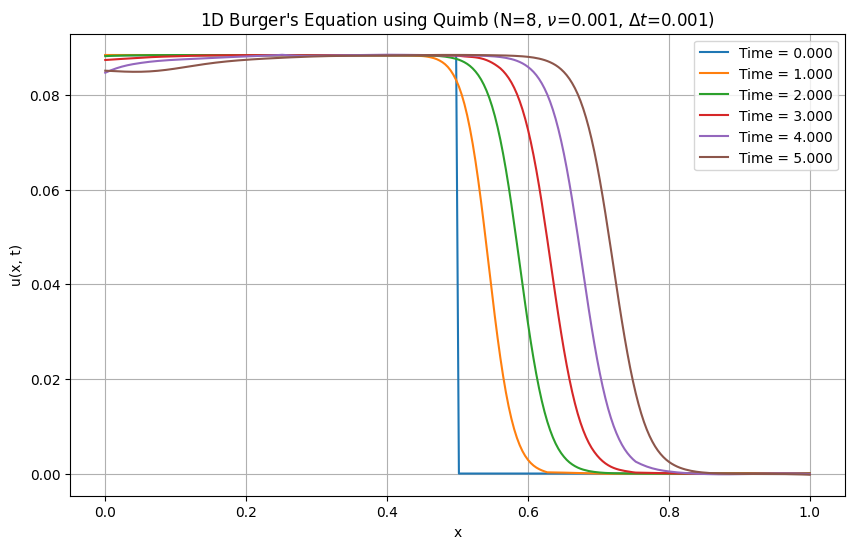

In [19]:
# --- Plotting Results ---
plt.figure(figsize=(10, 6))
for i, u_dense in enumerate(u_history):
    plt.plot(x, u_dense, label=f'Time = {times[i]:.3f}')

plt.title(f'1D Burger\'s Equation using Quimb (N={N_sites}, $\\nu$={nu}, $\\Delta t$={dt})')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.legend()
plt.grid(True)
plt.show()

This technique of adding a penalty term is not exact but approximate, because of that we see some curves starting at 0.9, 0.95 and even around 0.98. the strength of the penalty term should be choosen experimentally for each problem. Strating with very small values and increasing till reaching a satisfying approximation.

### Comparison with the analytical solution:

we will now plot the analytical solution and compare the plots of the analytical solution with the ones obtained from using the quantum inspired algorithm.

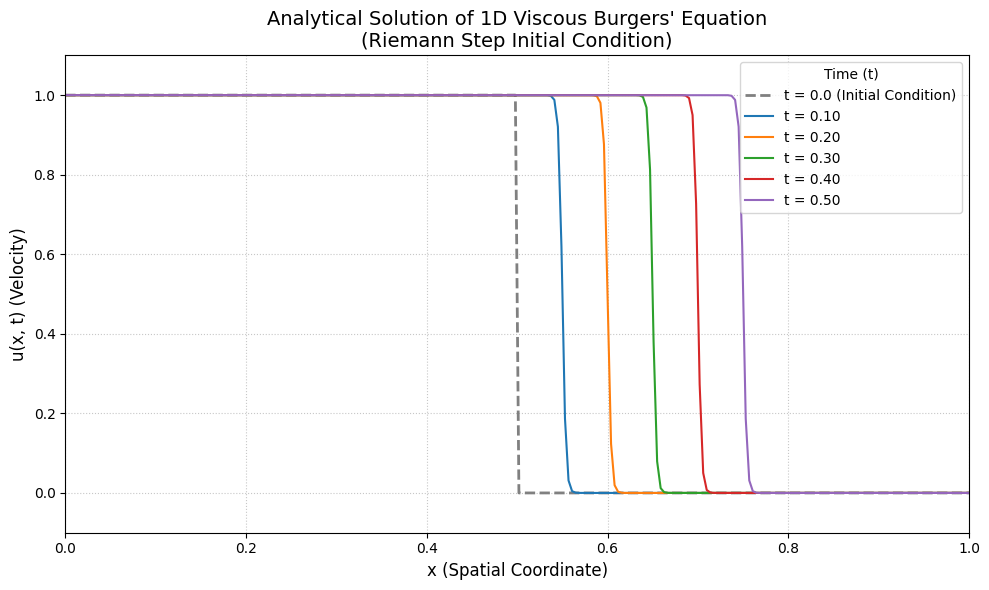

In [25]:
def burgers_analytical_solution(x, t, u_L, u_R, x0, nu):
    """
    Calculates the analytical solution for the 1D viscous Burgers' equation
    with a step-like initial condition.

    The solution is derived using the Hopf-Cole transformation, which converts
    the non-linear Burgers' equation into a linear heat equation.

    Args:
        x (numpy.ndarray): Array of spatial points.
        t (float): Time at which to calculate the solution.
        u_L (float): Velocity value for the left side of the initial step (x < x0).
        u_R (float): Velocity value for the right side of the initial step (x >= x0).
        x0 (float): Initial position of the step discontinuity.
        nu (float): Kinematic viscosity, which controls the smoothing of the shock.

    Returns:
        numpy.ndarray: Velocity u(x, t) at the given spatial points and time.
    """
    # The argument for the hyperbolic tangent function determines the shape
    # and position of the shock wave.
    # (u_L - u_R) / (4 * nu) controls the steepness of the shock.
    # (x - x0 - (u_L + u_R) / 2 * t) determines the position of the shock center,
    # where (u_L + u_R) / 2 is the shock speed.
    arg = (u_L - u_R) / (4 * nu) * (x - x0 - (u_L + u_R) / 2 * t)

    # The solution is a hyperbolic tangent profile, which smoothly transitions
    # between u_L and u_R.
    u = (u_L + u_R) / 2 - (u_L - u_R) / 2 * np.tanh(arg)
    return u

# --- Parameters for the Burgers' Equation ---
u_left_state = 1.0  # Velocity value on the left side of the initial step
u_right_state = 0.0 # Velocity value on the right side of the initial step
initial_step_pos = 0.5 # The x-coordinate where the initial step occurs
kinematic_viscosity = 0.001 # Viscosity (nu). A smaller value makes the shock sharper.

# --- Spatial Domain ---
# Define the range for x from 0 to 1 with a sufficient number of points
# to create a smooth curve.
x_points = np.linspace(0, 1, 256)

# --- Time Points for Plotting ---
# Choose several time values to observe the evolution of the solution.
# t=0.0 represents the initial condition.
time_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

# --- Plotting the Solutions ---
plt.figure(figsize=(10, 6)) # Set the figure size for better readability

# Plot the initial condition (t=0) separately for clarity, using a dashed line.
# np.where is used to create the exact step function for t=0.
initial_u_profile = np.where(x_points < initial_step_pos, u_left_state, u_right_state)
plt.plot(x_points, initial_u_profile, label=f't = 0.0 (Initial Condition)',
         linestyle='--', color='gray', linewidth=2)

# Plot the analytical solution for subsequent time steps.
for t in time_values[1:]: # Iterate through time_values, skipping the first (t=0)
    # Calculate the velocity profile at the current time t
    u_at_t = burgers_analytical_solution(x_points, t, u_left_state, u_right_state,
                                         initial_step_pos, kinematic_viscosity)
    # Plot the profile
    plt.plot(x_points, u_at_t, label=f't = {t:.2f}') # Format time to two decimal places

# --- Customize the Plot ---
plt.title("Analytical Solution of 1D Viscous Burgers' Equation\n(Riemann Step Initial Condition)",
          fontsize=14)
plt.xlabel("x (Spatial Coordinate)", fontsize=12)
plt.ylabel("u(x, t) (Velocity)", fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7) # Add a grid for better readability
plt.legend(title="Time (t)", loc='upper right', fontsize=10) # Add a legend
plt.ylim(-0.1, 1.1) # Set y-axis limits to clearly show the range from 0 to 1
plt.xlim(0, 1) # Set x-axis limits as specified in the problem
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show() # Display the plot

The curves above, look very similar to the curves we got but with one major difference, the plots for the analytical (exact solution) are at times [0.1, 0.2, 0.3, 0.4, 0.5]. While for the quantum inspired solution are at times [1.0, 2.0, 3.0, 4.0, 5.0]. So what went wrong?

In fact, nothing went wrong and such thing is even shown in the paper about QTN provided by the challenge guidelines.

In figure 5 of the paper "Complete quantum-inspired framework for computational fluid dynamics" in page 6, when comparing to "Ansys fluent", they did not compare at any random time. They chose the time when both algorithms have reached the required phase. By here we mean the time T steps iterations. They let both evolve to a high enough same T so that both reach the same phase.

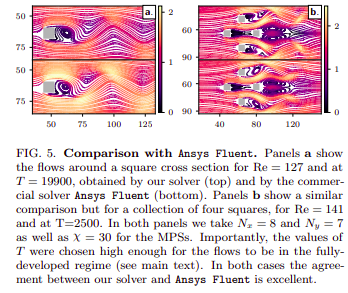

As shown in the following figure, T is the number of iterations, each iteration performs a ${\delta}$t step.

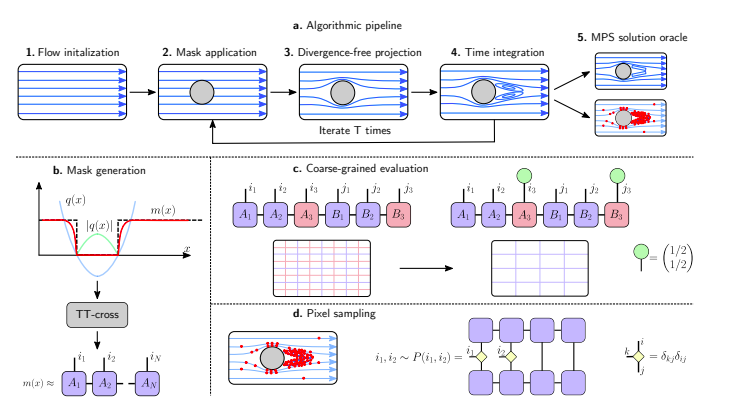

1. Section IV (p. 5, just before Fig. 5)
“We note that comparison between conceptually different solvers are meaningful only in the fully developed phase of the flow, after the initial transient behaviour. The evolution times used for Fig. 5 were carefully chosen as to guarantee this condition (see App. E).”

2. Appendix E (p. 10, opening paragraph)
“We remark that no comparison with Ansys Fluent is presented for these cases, as the flow is still in a developing phase. In fact, no comparison between the two solvers is meaningful until the fully developed phase of the flow, after the initial transient behaviour.”

Both of these make clear that you shouldn’t expect Solver A’s wake to look like Solver B’s at the same physical time—each has its own transient rate—so only align them once both have settled into the fully developed regime.

It is worth mentioning that time T is the physical time, which is the number of steps T of time evolution and not the time required by the CPU/GPU or hardware to finish.

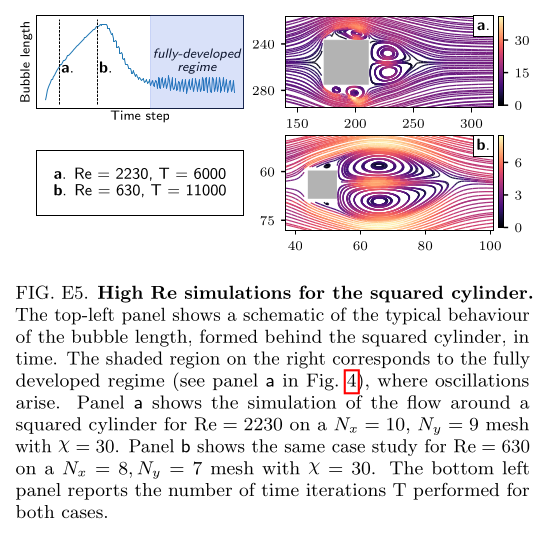

Another picture that supports this is that in the above figure they are using the MPS algorithm for two different High Reynold's numbers. As this number became very high, the step δt became even smaller which requires hugher T steps to run. They mentioned in appendix E when talking about these two figures that the comparison between Ansys fluent and these two figures is worethless since the full-developed region has not been reached yet. So even if we use both the MPS algorithm and Ansys fluent with same T and δt, both algorithm evlove at different time scales, one might evolve faster or slower, so we need to wait for the fully-developed phase which is the stage where the flow has settled into a characteristic behavior, such as periodic vortex shedding behind the obstacle. Here although still eveovling but in a peridoc predicatable manner and not unpredicatable and unperiodic / random as in the phase before the fully-developed.

Some parts in our solution that can lead to such phenomena are:
<ul>
<li>Truncation after each MPS operation using compression.</li>
<li>Euler which is an approximation and not 100% accurate.</li>
</ul>
Such approximations or methods lead to different behaviour like plot moving velocity and accuracy/shape in the transient phase before reaching the steady/stable fully-developed phase.

In our case we are using 1D and not 2D/3D like the navier stokes equations, so we cannot plot 2D/3D plots like the ones above. So we will compare the 1D velocity vectors using comparison techniques like L2-error when they reach approximately the same shape. This is for the first plot approximately at time t=1.0 for the MPS algortihm and at time t=0.1 for the analytical solution. By this way we are making a fair comarison between different solvers, analytical and MPS as they have made above between MPS and Ansys fluent.

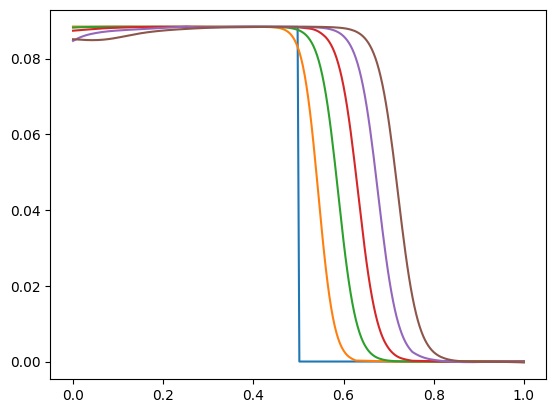

In [32]:
for i, u_dense in enumerate(u_history):
    plt.plot(x, u_dense, label=f'Time = {times[i]:.3f}')

In [33]:
#L2 error between two vectors
#L2 = ||A - B||₂

#Analytical solution at t=0.1
A = burgers_analytical_solution(np.linspace(0, 1, 256), 0.1, 1.0, 0.0, 0.5, 0.001)
#MPS solution at t=1.0
for i, u_dense in enumerate(u_history):
    if i == 1:
      B = u_dense
A /= np.linalg.norm(A)
B /= np.linalg.norm(B)
l2_error = np.linalg.norm(A - B)

print(f"L2-error between A and B: {l2_error}")

L2-error between A and B: 15.069663007035418


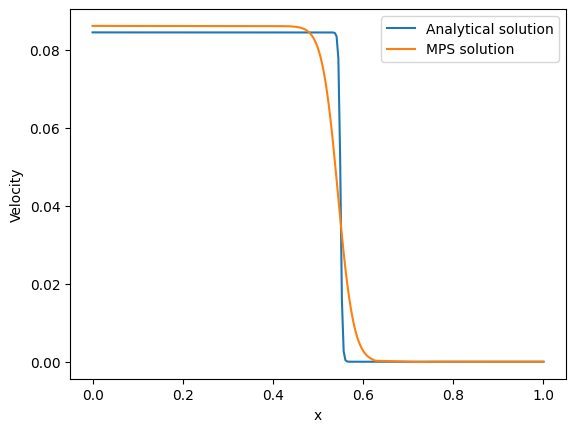

In [34]:
plt.plot(np.linspace(0, 1, 256), A, label='Analytical solution')
plt.plot(np.linspace(0, 1, 256), B, label='MPS solution')
plt.xlabel('x')
plt.ylabel('Velocity')
plt.legend()

### Versions:

In [ ]:
import platform
print("Python version:", platform.python_version())

In [ ]:
import quimb
print("Quimb version:", quimb.__version__)